In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
!pip install np_utils

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Input, LSTM, concatenate, AveragePooling2D
from tensorflow.keras.layers import Subtract, Conv2D, GlobalMaxPooling2D, Reshape, Conv2DTranspose, UpSampling2D, Embedding
from tensorflow.keras import regularizers
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from matplotlib import pyplot as plt

import numpy as np

Using TensorFlow backend.


In [0]:
#parameters
epsilon = 0.01  #the quantity of perturbation we add to the images
step_pgd = 20   #the number of steps taken during the PGD algo
eta = 0.005     #used in PGD algo

# Data

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
x_train = x_train / 255
x_test = x_test / 255

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Network

In [0]:
# (Conv + ReLU + MaxPool)x3 + AvgPool + FC + ReLU + FC (fully connected)
input = tf.keras.Input(shape=(32, 32, 3))
x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x) 

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

adversarial = keras.models.Model(inputs=input, outputs=x)
adversarial.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
history = adversarial.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 27s 670us/sample - loss: 1.6746 - accuracy: 0.4024 - val_loss: 1.4335 - val_accuracy: 0.4943
Epoch 2/10
40000/40000 [==============================] - 25s 626us/sample - loss: 1.3529 - accuracy: 0.5235 - val_loss: 1.2970 - val_accuracy: 0.5531
Epoch 3/10
40000/40000 [==============================] - 25s 629us/sample - loss: 1.2529 - accuracy: 0.5634 - val_loss: 1.2281 - val_accuracy: 0.5759
Epoch 4/10
40000/40000 [==============================] - 25s 626us/sample - loss: 1.1770 - accuracy: 0.5892 - val_loss: 1.2034 - val_accuracy: 0.5845
Epoch 5/10
40000/40000 [==============================] - 25s 629us/sample - loss: 1.1183 - accuracy: 0.6113 - val_loss: 1.1427 - val_accuracy: 0.6067
Epoch 6/10
40000/40000 [==============================] - 25s 629us/sample - loss: 1.0778 - accuracy: 0.6284 - val_loss: 1.1398 - val_accuracy: 0.6084
Epoch 7/10
40000/40000 [====================

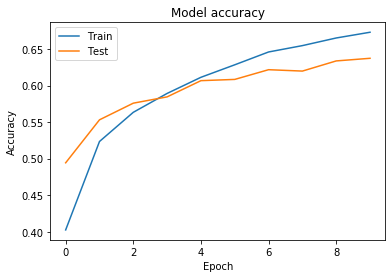

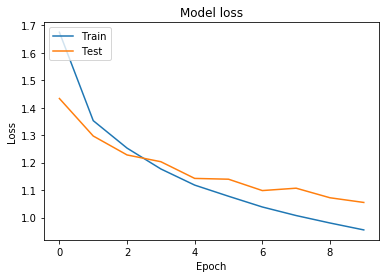

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Perturbations (FGSM, norme infinie)

In [0]:
#create the perturbations
#the perturbations are on the test set
image = tf.cast(x_test, tf.float32)
    
with tf.GradientTape() as tape:
  tape.watch(image)
  prediction = adversarial(image)
  loss = tf.keras.losses.MSE(y_test, prediction)
    
gradient = tape.gradient(loss, image)
    
perturbations = tf.sign(gradient).numpy()
print(type(perturbations))
print(perturbations.shape)

x_test_fgsm = x_test + perturbations * epsilon

<class 'numpy.ndarray'>
(10000, 32, 32, 3)


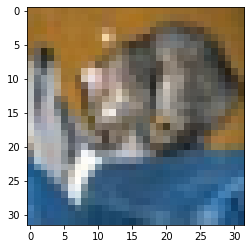

In [0]:
#the original image
plt.imshow(x_test[0].reshape((32, 32, 3)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


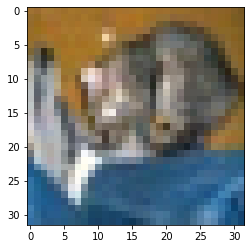

In [0]:
#the modified image (FGSM)
plt.imshow(x_test_fgsm[0].reshape((32, 32, 3)))
plt.show()

In [0]:
#results for the original image
print(adversarial.evaluate(x_test, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [0]:
#results for the modified image
print(adversarial.evaluate(x_test_fgsm, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

# Perturbations (PGD, norme infinie)

In [0]:
#create the perturbations
x_test_pgd = np.copy(x_test)
image_ref = tf.cast(x_test, tf.float32)
    
for step in range(step_pgd):
  image = tf.cast(x_test_pgd, tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = adversarial(image)
    loss = tf.keras.losses.MSE(y_test, prediction)
      
  gradient = tape.gradient(loss, image)
      
  perturbations = tf.sign(gradient).numpy()
  x_test_pgd = x_test_pgd + perturbations * eta
  x_test_pgd = np.maximum(np.minimum(x_test_pgd, x_test + epsilon), x_test - epsilon)

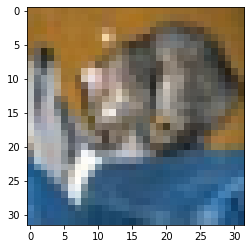

In [0]:
#the original image
plt.imshow(x_test[0].reshape((32, 32, 3)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


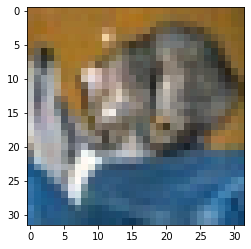

In [0]:
#the modified image (PGD)
plt.imshow(x_test_pgd[0].reshape((32, 32, 3)))
plt.show()

In [0]:
#results for the modified image
print(adversarial.evaluate(x_test_pgd, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================